In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2 
import warnings
warnings.filterwarnings("ignore")

## Import 

In [2]:
# Run the model on the images in this path 
image_path='./data/HAM10000_images'

# preprocess into this path
processed_image_path='./data/processed_images'

## Variables

In [3]:
# Declare width and height of the patches
r=6

#Set canny filter
canny_A=100
canny_B=100

# Set thresholds
max_lines_cap=99 # Check density above this cap
max_density_cap=123 # Check density history variance above this cap
max_hist_variance_cap=5 # Even distribution below this threshold
max_std_dev_cap=0.30 # Even distribution below this threshold
max_variance_cap=0.10 # Even distribution below this threshold
max_hist_variance=30 # Maximum allowed density history variance

## Functions

- bresenham : to calculate intermediate points in a line
- detection_points : create a list of all coordinates to patch
- reduce_points : to remove adjacent points (optional)
- histogram_distribution : returns the variance in the density histogram
- get_density : calculates density in a gridsize grid
- plot_density : plots the density grid and the density histogram
- hair_removal : processes and writes processed images (detected lines and patched image)


In [4]:
# This algorithm generates a list of all the points that are r units away from each other on a line
 
def bresenham(x1, y1, x2, y2, r):
    # Calculate the difference between the start and end points
    dx = x2 - x1
    dy = y2 - y1

    # Calculate the length of the line
    line_length = math.sqrt(dx**2 + dy**2)

    # Calculate the number of steps needed
    steps = int(line_length / r)

    # Calculate the step size in x and y
    x_inc = dx / steps
    y_inc = dy / steps

    # Generate a list of points with a distance of r
    points = []
    for i in range(steps):
        x = x1 + i * x_inc
        y = y1 + i * y_inc
        points.append((x, y))

    return points

In [5]:
# Calculate all points to process from the houghlines and bresenhem function

def detection_points(source,new_img,linesP,r):
    
    all_points=[] 
    
    for line in linesP:
        x1,y1,x2,y2 = line[0] 

        # Draw the detected lines on new_img
        cv2.line(new_img,(x1,y1),(x2,y2),(0,255,0),2)

        # Get (n) points on the line to process
        intermedian_points=bresenham(x1, y1, x2, y2, (r))
        all_points.extend(intermedian_points)

    return source,new_img,all_points


In [6]:
# Reduce the number of points
def reduce_points(points):
    
    filtered_points = []

    # iterate through the points
    for i in range(len(points)):
        # assume that the current point is not next to any other point
        is_next_to_another_point = False
        # check if the current point is next to any of the previous points
        for j in range(i):
            if abs(points[i][0] - points[j][0]) <= 2 and abs(points[i][1] - points[j][1]) <= 2:
                is_next_to_another_point = True
                break
        # add the current point to the filtered list if it's not next to any other point
        if not is_next_to_another_point:
            filtered_points.append(points[i])

    # return the filtered points
    return filtered_points

In [7]:
def histogram_distribution(H_flat_norm):
    
    # Declare the number of bins for the histogram
    num_bins = 10

    # Convert H to a numpy array
    H = np.array(H_flat_norm)

    # Calculate the variance of the values in H
    variance = np.var(H)

    # Calculate the histogram of the values in H
    hist, bin_edges = np.histogram(H, bins=num_bins, range=(0, 1))

    # Calculate the variance of the histogram bins
    variance = np.var(hist)

    # Determine if the values are evenly distributed or concentrated
    if variance < 5:
        print ('Histogram variance is:',variance, 'The densities are evenly distributed across the grid')
    else:
        print ('Histogram variance is:',variance, 'The densities are not evenly distributed')

    return variance

In [8]:
# Function to calculate the density,std_dev,variance,and density histogram variance in a grid of (gridsize,gridsize)
# When density is higher than (max_density_cap) it will also plot the density grid

def get_density(points,gridsize):

    xlim = [0, 600]
    ylim = [0, 450]
 
    x=[]
    y=[]
    
    for point in points:
        x1,y1=point
        x.append(int(x1))
        y.append(int(y1))
        
    # Calculate density histogram
    D, xedges, yedges = np.histogram2d(x, y, bins=gridsize, range=[xlim, ylim])
    
    # Calculate density from histogram
    D_flat=D.flatten()
    D_max = np.max(D_flat)
    D_norm = D / D_max
    D_norm_flat=D_norm.flatten()

    print ('Maximum density :',D_max)
    max_density=D_max

    variance = np.var(D_norm_flat)
    #print ("Variance:", variance)

    std_dev = np.std(D_norm_flat) 
    #print ("Standard deviation:",std_dev) 

    points = np.column_stack((x, y))
    hist_variance = histogram_distribution(D_norm_flat)

    if max_density>max_density_cap:
        
        plot_density(x,y,D)

    return max_density,hist_variance,std_dev,variance

def plot_density(x,y,D):
    
    # Size of source
    xlim = [0, 600]
    ylim = [0, 450]

    # Set a 5x5 grid
    gridsize = 5

    # Flatten density
    D_flat=D.flatten()

    # Set the density values to a colormap
    cmap = plt.cm.get_cmap('viridis_r')
    
    # Create density grid plot
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(D.T, origin='upper', extent=[xlim[0], xlim[1], ylim[1], ylim[0]], cmap=cmap)
    ax.scatter(x, y, color='orange')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax,shrink=0.5)
    cbar.set_label('Density')
    plt.show()
    
    # Create density histogram
    cnts, values, bars = plt.hist(D_flat, bins=gridsize**2, alpha=0.8, density=False)
 
    plt.xlabel('Density')
    plt.ylabel('Count')  
    
    plt.show()

In [9]:

def hair_removal(image):

    # height, width of image
    height = image.shape[0]
    width = image.shape[1]
    
    # Define global variables for use in the hair removal function
    global r, source
    
    # Define source image 
    source=image.copy()

    # Define the desination image 
    new_img=image.copy()

    # Define grayscale image for canny
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply canny edge detection
    edges= cv2.Canny(gray,canny_A, canny_B)
    plt.imshow(edges,cmap = 'gray')
    plt.show()
    
    # Line detection with Probabilistic Line Transform
    linesP = cv2.HoughLinesP(edges, cv2.HOUGH_PROBABILISTIC, np.pi / 720, 35, 1, 5, 16)
    if linesP is not None:
        print(len(linesP),'lines detected')
 
    # Process the lines if there are less than 600
    if (linesP is not None) and (len(linesP)<600):
        skip_this_image=False

        source,new_img,all_points= detection_points(source,new_img,linesP,r)
        max_density,histogram_variance,std_dev,variance=get_density(all_points,gridsize=5)

        filtered_points=reduce_points(all_points)
        filtered_points=all_points

        if ((skip_this_image==False) and (max_density>max_density_cap)):
            # Skip if the histogram variance is greater than this max
            if histogram_variance>max_hist_variance:
                print ("** SKIPPING : Reason : TOO BIG HIST VARIANCE:",histogram_variance)
                skip_this_image=True

            # Skip if the variance is too great
            if variance>max_variance_cap:
                print ("** SKIPPING : Reason : TOO BIG VARIANCE:",histogram_variance)
                skip_this_image=True

            if ((skip_this_image==False)and(len(linesP)>max_lines_cap)):

                if (std_dev>max_std_dev_cap):            
                    print ("** SKIPPING : Reason : TOO BIG STD:",std_dev)
                    skip_this_image=True

                # SMALL VARIANCE MEANS EQUAL DISTRIBUTION MEANS it's OK to have a high density
                if ((skip_this_image==False) and (max_density>max_density_cap)and(histogram_variance>max_hist_variance_cap)):
                    print ("** SKIPPING : Reason : TOO BIG DENSITY AND HIST VARIANCE:",max_density)
                    skip_this_image=True
                
                if ((skip_this_image==False) and (max_density>max_density_cap)and (std_dev>max_std_dev_cap)):            
                    print ("** SKIPPING : Reason : TOO BIG DENSITY AND STD:",std_dev)
                    skip_this_image=True

        if skip_this_image==False:
            print ('---- HAIRS DETECTED ----')
            for i in range(0, 32):
                for point in filtered_points:
                    x1,y1=point
                    x1=int(x1)
                    y1=int(y1)
                    
                    # Make sure to not search around the edges
                    if x1>r and y1>r and x1<width-r and y1<height-r:
                        
                        try: 
                            for i in range(0,2*r):
                                for j in range(0,2*r):
                                    
                                    y_replaced = y1-r+i
                                    x_replaced = x1-r+j

                                    top = 0.25 * source[y_replaced-2*r][x_replaced]
                                    left = 0.25 * source[y_replaced][x_replaced-2*r]
                                    bottom = 0.25 * source[y_replaced+2*r][x_replaced]
                                    right = 0.25 * source[y_replaced][x_replaced+2*r]
                                    
                                    source[y_replaced][x_replaced] = left + top + right + bottom + (np.random.uniform(-5, 5, 1)[0],np.random.uniform(-5, 5, 1)[0],np.random.uniform(-5, 5, 1)[0])

                            
                        except:
                            pass               
    return (new_img,source)
 

## Process

ISIC_0024306.jpg


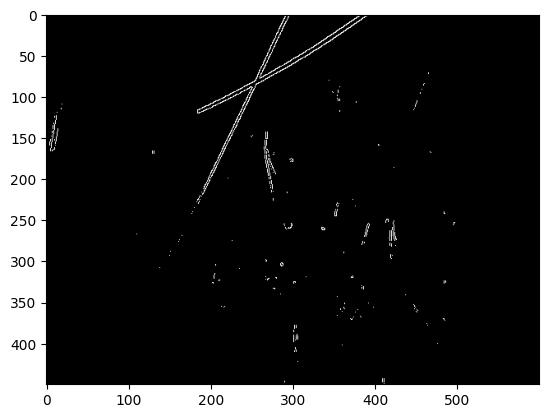

16
Maximum density : 119.0
Histogram variance is: 34.45 The densities are not evenly distributed
---- HAIRS DETECTED ----
ISIC_0024307.jpg


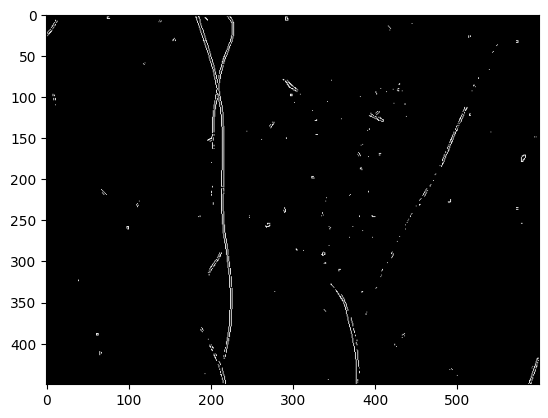

29
Maximum density : 48.0
Histogram variance is: 27.25 The densities are not evenly distributed
---- HAIRS DETECTED ----
ISIC_0024308.jpg


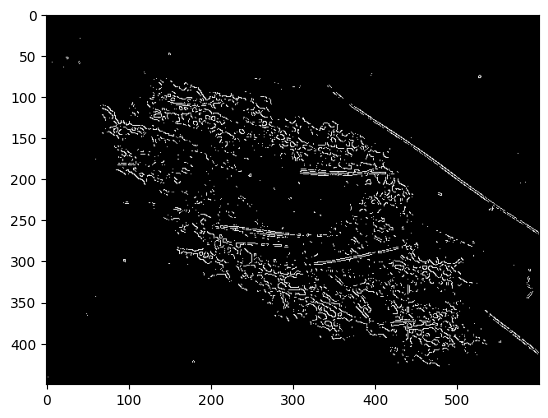

346
Maximum density : 421.0
Histogram variance is: 7.25 The densities are not evenly distributed


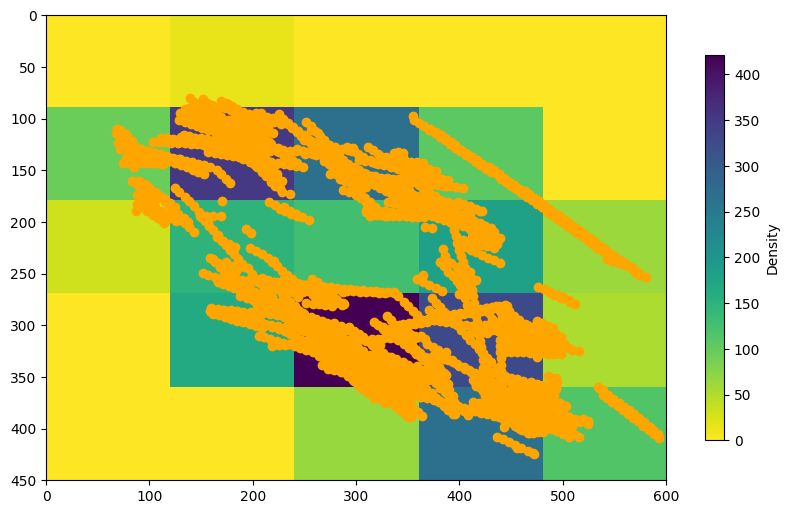

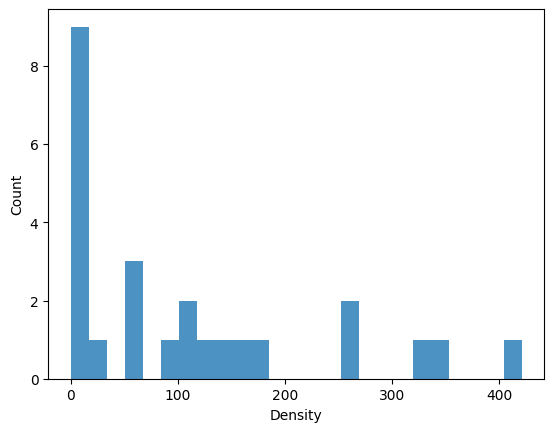

** SKIPPING : Reason : TOO BIG DENSITY AND HIST VARIANCE: 421.0
ISIC_0024309.jpg


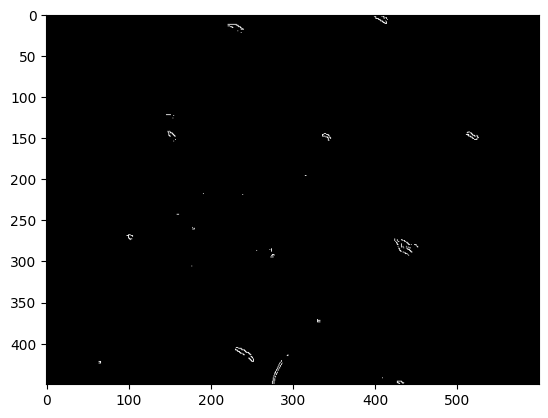

ISIC_0024310.jpg


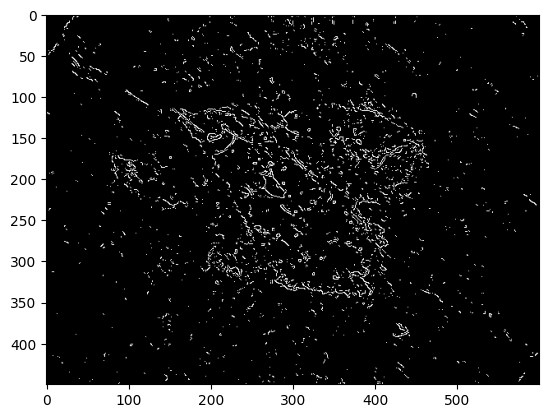

224
Maximum density : 263.0
Histogram variance is: 18.05 The densities are not evenly distributed


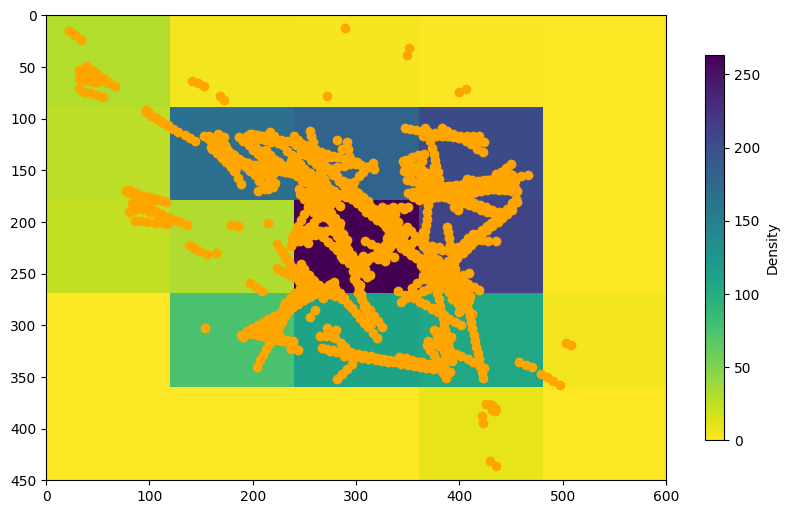

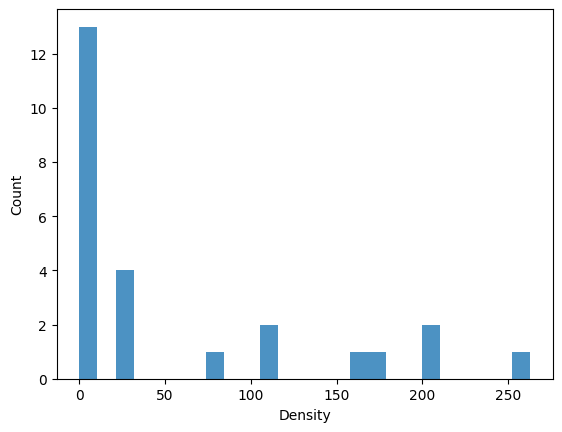

** SKIPPING : Reason : TOO BIG STD: 0.3063600386401601
ISIC_0024311.jpg


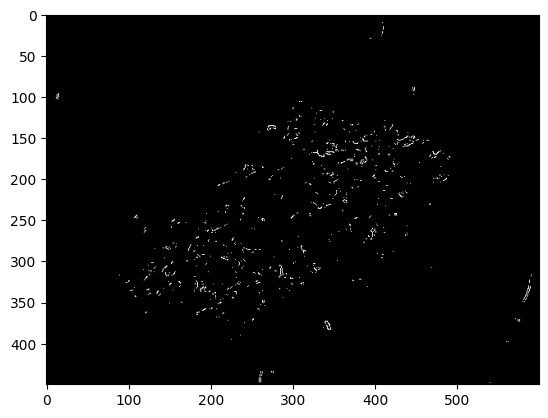

ISIC_0024312.jpg


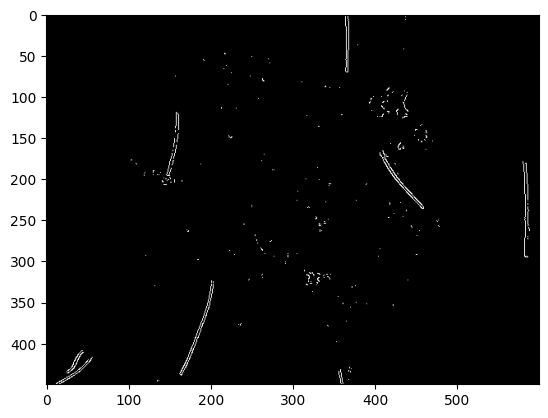

15
Maximum density : 38.0
Histogram variance is: 23.85 The densities are not evenly distributed
---- HAIRS DETECTED ----
ISIC_0024313.jpg


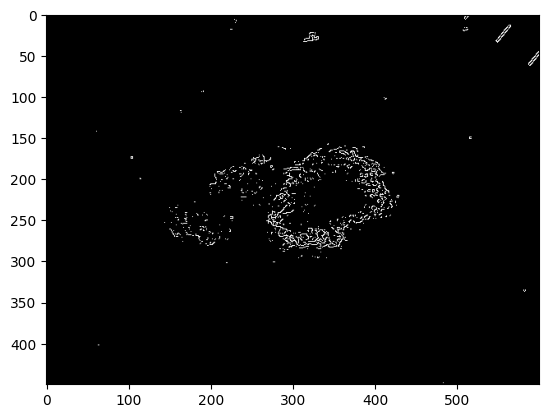

18
Maximum density : 59.0
Histogram variance is: 31.05 The densities are not evenly distributed
---- HAIRS DETECTED ----


In [10]:
for image_file in os.listdir(image_path):
    print (image_file)
    image = cv2.imread(os.path.join(image_path,image_file))
    processed_image, clean_processed_image= hair_removal(image)
    
    cv2.imwrite(os.path.join(processed_image_path,'phough',f'p{image_file}'), processed_image) 
    cv2.imwrite(os.path.join(processed_image_path,image_file), clean_processed_image)  
